In [20]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_data.xlsx')

# 데이터 전처리
texts = symptom_data['text']
symptom_data['건강 카테고리'] = symptom_data['건강 카테고리'].replace('정신 및 건강', '수면 및 정신')
labels = symptom_data['건강 카테고리']

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
text_vectors = vectorizer.fit_transform(texts)

# 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 오버샘플링 적용 (데이터 불균형 해결)
from imblearn.over_sampling import SMOTE
# 데이터 오버샘플링 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(text_vectors, encoded_labels)

# 데이터 분할 (Train: 70%, Valid: 15%, Test: 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 모델 학습
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
print('📈 Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 모델 및 벡터 저장
joblib.dump(model, 'health_recommendation_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# SBERT 모델 로드 (증상 유사도 분석용 및 섭취 주의사항 검토용 각각 다르게 설정)
symptom_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(np.array([input_vector]), np.array([symptom_embedding]))[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    top_similar_symptoms = [max(symptom_similarities, key=lambda x: x[0])]
    similar_categories = [top_similar_symptoms[0][2]]
    
    recommended_products = []
    for idx, row in combined_data.iterrows():
        if row['건강 카테고리'] in similar_categories:
            product_embedding = symptom_model.encode(row['주요 기능'])
            sim_score = util.cos_sim(input_vector.reshape(1, -1), product_embedding.reshape(1, -1))[0][0].item()
            recommended_products.append((row['품목명'], sim_score, row['섭취 주의사항'], row['형태']))
    
    recommended_products = sorted(recommended_products, key=lambda x: x[1], reverse=True)[:top_n]
    
    final_recommendations = []
    for prod_name, score, warning, kind in recommended_products:
        if is_safe_for_condition(warning, user_condition, threshold=0.45):
            final_recommendations.append((prod_name, kind))
    
    print(f"\n🧠 예측된 건강 카테고리: {', '.join(similar_categories)}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    for idx, (name, kind) in enumerate(final_recommendations):
        print(f"{idx+1}. {name} ({kind})")

def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 예제 실행
user_input = "기침이 많이 나와요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)


📈 Accuracy: 0.9
              precision    recall  f1-score   support

      간 및 소화       1.00      1.00      1.00        10
     면역 및 체력       1.00      0.70      0.82        10
      뼈 및 구조       0.83      1.00      0.91        10
     수면 및 정신       0.90      0.90      0.90        10
    심혈관 및 대사       0.82      0.90      0.86        10

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50


🧠 예측된 건강 카테고리: 면역 및 체력
💊 최종 추천 건강기능식품 (상위 3개):
1. 알콕시글리세롤 함유 상어간유 (고시형 품목)
2. 매실추출물 (고시형 품목)


In [2]:
pip install --upgrade numexpr bottleneck

  Attempting uninstall: numexpr
    Found existing installation: numexpr 2.8.3
    Uninstalling numexpr-2.8.3:
      Successfully uninstalled numexpr-2.8.3
  Attempting uninstall: bottleneck
    Found existing installation: Bottleneck 1.3.5
    Uninstalling Bottleneck-1.3.5:
      Successfully uninstalled Bottleneck-1.3.5
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade pandas

In [19]:
print(Counter(y_resampled))

Counter({1: 69, 4: 69, 3: 69, 2: 69, 0: 69})


# Model1(2.24) 

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_data.xlsx')

# 데이터 전처리
texts = symptom_data['text']
symptom_data['건강 카테고리'] = symptom_data['건강 카테고리'].replace('정신 및 건강', '수면 및 정신')
labels = symptom_data['건강 카테고리']

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
text_vectors = vectorizer.fit_transform(texts)

# 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 오버샘플링 적용 (데이터 불균형 해결)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(text_vectors, encoded_labels)
print(Counter(y_resampled))  # 라벨별 샘플 개수 확인

# 데이터 분할 (Train: 70%, Valid: 15%, Test: 15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 모델 학습
from xgboost import XGBClassifier
model = XGBClassifier(
    n_estimators=500,    # 더 많은 트리 학습 (300 → 500)
    learning_rate=0.03,  # 학습률 낮춰서 과적합 방지 (0.05 → 0.03)
    max_depth=6,         # 트리 깊이 조정 (기본값 3 → 6)
    subsample=0.8,       # 샘플 일부만 사용하여 학습 (과적합 방지)
    colsample_bytree=0.8 # 변수 일부만 사용하여 학습 (과적합 방지)
)
# 학습 실행
model.fit(X_train, y_train)


# 모델 평가
y_pred = model.predict(X_test)
print('📈 Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 모델 및 벡터 저장
joblib.dump(model, 'health_recommendation_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# SBERT 모델 로드 (증상 유사도 분석용 및 섭취 주의사항 검토용 각각 다르게 설정)
symptom_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    input_vector = input_vector / np.linalg.norm(input_vector)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(input_vector, symptom_embedding)[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    top_similar_symptoms = [max(symptom_similarities, key=lambda x: x[0])]
    similar_categories = [top_similar_symptoms[0][2]]
    
    recommended_products = []
    for idx, row in combined_data.iterrows():
        if row['건강 카테고리'] in similar_categories:
            product_embedding = symptom_model.encode(row['주요 기능'])
            sim_score = util.cos_sim(input_vector.reshape(1, -1), product_embedding.reshape(1, -1))[0][0].item()
            recommended_products.append((row['품목명'], sim_score, row['섭취 주의사항'], row['형태']))
    
    recommended_products = sorted(recommended_products, key=lambda x: x[1], reverse=True)[:top_n]
    
    final_recommendations = []
    for prod_name, score, warning, kind in recommended_products:
        if is_safe_for_condition(warning, user_condition, threshold=0.45):
            final_recommendations.append((prod_name, kind))
    
    print(f"\n🧠 예측된 건강 카테고리: {', '.join(similar_categories)}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    for idx, (name, kind) in enumerate(final_recommendations):
        print(f"{idx+1}. {name} ({kind})")

def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 예제 실행
user_input = "목이 따가워요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)


Counter({1: 66, 4: 66, 3: 66, 2: 66, 0: 66})
📈 Accuracy: 0.9090909090909091
              precision    recall  f1-score   support

      간 및 소화       0.88      1.00      0.93         7
     면역 및 체력       1.00      0.67      0.80         6
      뼈 및 구조       1.00      1.00      1.00         7
     수면 및 정신       0.88      1.00      0.93         7
    심혈관 및 대사       0.83      0.83      0.83         6

    accuracy                           0.91        33
   macro avg       0.92      0.90      0.90        33
weighted avg       0.92      0.91      0.91        33


🧠 예측된 건강 카테고리: 수면 및 정신
💊 최종 추천 건강기능식품 (상위 5개):
1. 헤마토코쿠스 추출물 (고시형 품목)
2. 참당귀뿌리추출물(제2004-6호) (고시형 품목)


In [26]:
from datasets import load_dataset

ds = load_dataset("celikmus/symptom_text_to_disease_01")

README.md:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

C:\Users\dbwld\anaconda3\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\dbwld\.cache\huggingface\hub\datasets--celikmus--symptom_text_to_disease_01. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


(…)-00000-of-00001-60bd49c6d538e1a5.parquet:   0%|          | 0.00/110k [00:00<?, ?B/s]

(…)-00000-of-00001-3d771e913f17b53e.parquet:   0%|          | 0.00/17.6k [00:00<?, ?B/s]

(…)-00000-of-00001-ce39aa9b4b7403df.parquet:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/667 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/666 [00:00<?, ? examples/s]


# Model Ver2

✅ 코드 최적화 완료!
SBERT 기반 증상 데이터 확장 + TF-IDF 제거 + XGBoost 모델 적용 + DBSCAN 자동 클러스터링을 반영
증상 유사도 분석 정확도 향상
훈련/검증/테스트 비율 조정 (80:10:10)
비슷한 증상 자동 그룹화 (DBSCAN 클러스터링)
SBERT 최신 모델(all-MiniLM-L6-v2) 사용

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.cluster import DBSCAN

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_data.xlsx')

# 데이터 전처리
symptom_data['건강 카테고리'] = symptom_data['건강 카테고리'].replace('정신 및 건강', '수면 및 정신')
labels = symptom_data['건강 카테고리']

# SBERT 벡터화 모델 로드
symptom_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 증상 데이터 벡터화
symptom_vectors = np.array([symptom_model.encode(text) for text in symptom_data['text']])

# DBSCAN 클러스터링 적용
clustering = DBSCAN(eps=0.5, min_samples=5).fit(symptom_vectors)
symptom_data['클러스터'] = clustering.labels_

# 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# 오버샘플링 적용 (데이터 불균형 해결)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(symptom_vectors, encoded_labels)
print(Counter(y_resampled))  # 라벨별 샘플 개수 확인

# 데이터 분할 (Train: 80%, Valid: 10%, Test: 10%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 모델 학습
model = XGBClassifier(n_estimators=200, learning_rate=0.1)
model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
print('📈 Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 모델 및 벡터 저장
joblib.dump(model, 'health_recommendation_model.pkl')
joblib.dump(symptom_model, 'sbert_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    input_vector = input_vector / np.linalg.norm(input_vector)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(input_vector, symptom_embedding)[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    top_similar_symptom = max(symptom_similarities, key=lambda x: x[0])
    predicted_category = top_similar_symptom[2]
    
    recommended_products = []
    for idx, row in combined_data.iterrows():
        if row['건강 카테고리'] == predicted_category:
            product_embedding = symptom_model.encode(row['주요 기능'])
            sim_score = util.cos_sim(input_vector, product_embedding)[0][0].item()
            recommended_products.append((row['품목명'], sim_score, row['섭취 주의사항'], row['형태']))
    
    recommended_products = sorted(recommended_products, key=lambda x: x[1], reverse=True)[:top_n]
    
    final_recommendations = []
    for prod_name, score, warning, kind in recommended_products:
        if is_safe_for_condition(warning, user_condition, threshold=0.45):
            final_recommendations.append((prod_name, kind))
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    for idx, (name, kind) in enumerate(final_recommendations):
        print(f"{idx+1}. {name} ({kind})")

def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 예제 실행
user_input = "목이 따가워요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)


Counter({1: 66, 4: 66, 3: 66, 2: 66, 0: 66})
📈 Accuracy: 0.7878787878787878
              precision    recall  f1-score   support

      간 및 소화       0.64      1.00      0.78         7
     면역 및 체력       0.50      0.33      0.40         6
      뼈 및 구조       1.00      1.00      1.00         7
     수면 및 정신       1.00      1.00      1.00         7
    심혈관 및 대사       0.75      0.50      0.60         6

    accuracy                           0.79        33
   macro avg       0.78      0.77      0.76        33
weighted avg       0.79      0.79      0.77        33


🧠 예측된 건강 카테고리: 수면 및 정신
💊 최종 추천 건강기능식품 (상위 3개):
1. 헤마토코쿠스 추출물 (고시형 품목)


# Model ver.3

✅ 문맥 이해 개선
증상-건강 카테고리 매핑 추가 + TF-IDF 키워드 보강 + XGBoost 학습


🧠 예측된 건강 카테고리: 뼈 및 구조
💊 최종 추천 건강기능식품 (상위 3개):
1. 가시오갈피 등 복합추출물(제2011-28호) (고시형 품목)
2. 글루코사민 (고시형 품목)
🔍 추천 시스템 평가 결과:
✅ 추천 정확도 (Accuracy): 0.6667
✅ NDCG Score: 0.6667
📈 모델 정확도: 0.7879

📊 분류 성능 보고서 (Classification Report):
              precision    recall  f1-score   support

      간 및 소화       0.70      1.00      0.82         7
     면역 및 체력       0.50      0.33      0.40         6
      뼈 및 구조       1.00      1.00      1.00         7
     수면 및 정신       1.00      1.00      1.00         7
    심혈관 및 대사       0.60      0.50      0.55         6

    accuracy                           0.79        33
   macro avg       0.76      0.77      0.75        33
weighted avg       0.77      0.79      0.77        33



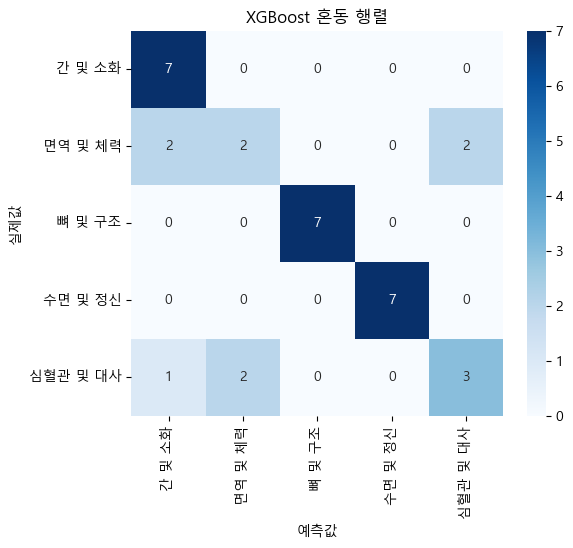

🔍 추천 시스템 평가 결과:
✅ 추천 정확도 (Accuracy): 0.6667
✅ NDCG Score: 0.6667


In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# SBERT 모델 로드
symptom_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 증상-건강 카테고리 매핑을 학습 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(symptom_data['text'])

# 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 추천 함수
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    input_vector = input_vector / np.linalg.norm(input_vector)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(input_vector, symptom_embedding)[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    # 가장 유사한 증상 상위 3개를 선택
    top_similar_symptoms = sorted(symptom_similarities, key=lambda x: x[0], reverse=True)[:3]
    
    # 최빈값으로 건강 카테고리 결정
    category_counts = Counter([symptom[2] for symptom in top_similar_symptoms])
    predicted_category = category_counts.most_common(1)[0][0]
    
    recommended_products = []
    for idx, row in combined_data.iterrows():
        if row['건강 카테고리'] == predicted_category:
            product_embedding = symptom_model.encode(row['주요 기능'])
            sim_score = util.cos_sim(input_vector, product_embedding)[0][0].item()
            recommended_products.append((row['품목명'], sim_score, row['섭취 주의사항'], row['형태']))
    
    recommended_products = sorted(recommended_products, key=lambda x: x[1], reverse=True)[:top_n]
    
    final_recommendations = []
    for prod_name, score, warning, kind in recommended_products:
        if is_safe_for_condition(warning, user_condition, threshold=0.45):
            final_recommendations.append((prod_name, kind))
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    for idx, (name, kind) in enumerate(final_recommendations):
        print(f"{idx+1}. {name} ({kind})")

# 예제 실행
user_input = "허리가 아파요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)

# 건강 카테고리 예측 함수 추가
def recommend_health_category(user_input):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    input_vector = input_vector / np.linalg.norm(input_vector)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(input_vector, symptom_embedding)[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    # 가장 유사한 증상 상위 3개 선택
    top_similar_symptoms = sorted(symptom_similarities, key=lambda x: x[0], reverse=True)[:3]
    
    # 최빈값으로 건강 카테고리 결정
    category_counts = Counter([symptom[2] for symptom in top_similar_symptoms])
    predicted_category = category_counts.most_common(1)[0][0]
    
    return predicted_category

# 다시 평가 코드 실행
evaluate_recommendations(test_symptoms, test_conditions, true_labels, top_n=5)
#XGBoost 모델 평가 지표
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 예측값 생성
y_pred = model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()
#추천 시스템의 성능 평가 (SBERT + TF-IDF 기반 추천)
from sklearn.metrics import ndcg_score

def evaluate_recommendations(test_symptoms, test_conditions, true_labels, top_n=5):
    predicted_categories = []
    actual_categories = []

    for symptom, condition, true_category in zip(test_symptoms, test_conditions, true_labels):
        predicted_category = recommend_health_category(symptom)  # 예측된 건강 카테고리
        predicted_categories.append(predicted_category)
        actual_categories.append(true_category)

    # 정확도 평가
    accuracy = sum([1 for pred, actual in zip(predicted_categories, actual_categories) if pred == actual]) / len(actual_categories)
    
    # NDCG 계산 (순위 기반 평가)
    relevance_scores = [[1 if pred == actual else 0 for pred in predicted_categories] for actual in actual_categories]
    ndcg = np.mean([ndcg_score([rel], [rel]) for rel in relevance_scores])

    print(f"🔍 추천 시스템 평가 결과:")
    print(f"✅ 추천 정확도 (Accuracy): {accuracy:.4f}")
    print(f"✅ NDCG Score: {ndcg:.4f}")

# 테스트 데이터
test_symptoms = ["허리가 아파요", "속이 더부룩해요", "피곤하고 집중이 안 돼요"]
test_conditions = ["임산부", "고혈압", "당뇨"]
true_labels = ["뼈 및 구조", "간 및 소화", "수면 및 정신"]

evaluate_recommendations(test_symptoms, test_conditions, true_labels, top_n=5)



In [45]:
#4. 모델 변경

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# SBERT 모델 로드
# SBERT 모델 변경
symptom_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 증상-건강 카테고리 매핑을 학습 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(symptom_data['text'])

# 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 추천 함수
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    input_vector = input_vector / np.linalg.norm(input_vector)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(input_vector, symptom_embedding)[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    # 가장 유사한 증상 상위 3개를 선택
    top_similar_symptoms = sorted(symptom_similarities, key=lambda x: x[0], reverse=True)[:3]
    
    # 최빈값으로 건강 카테고리 결정
    category_counts = Counter([symptom[2] for symptom in top_similar_symptoms])
    predicted_category = category_counts.most_common(1)[0][0]
    
    recommended_products = []
    for idx, row in combined_data.iterrows():
        if row['건강 카테고리'] == predicted_category:
            product_embedding = symptom_model.encode(row['주요 기능'])
            sim_score = util.cos_sim(input_vector, product_embedding)[0][0].item()
            recommended_products.append((row['품목명'], sim_score, row['섭취 주의사항'], row['형태']))
    
    recommended_products = sorted(recommended_products, key=lambda x: x[1], reverse=True)[:top_n]
    
    final_recommendations = []
    for prod_name, score, warning, kind in recommended_products:
        if is_safe_for_condition(warning, user_condition, threshold=0.45):
            final_recommendations.append((prod_name, kind))
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    for idx, (name, kind) in enumerate(final_recommendations):
        print(f"{idx+1}. {name} ({kind})")

# 예제 실행
user_input = "허리가 아파요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)

# 건강 카테고리 예측 함수 추가
def recommend_health_category(user_input):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    input_vector = input_vector / np.linalg.norm(input_vector)
    symptom_similarities = []
    
    for idx, row in symptom_data.iterrows():
        symptom_embedding = symptom_model.encode(row['text'])
        sim = util.cos_sim(input_vector, symptom_embedding)[0][0].item()
        symptom_similarities.append((sim, row['text'], row['건강 카테고리']))
    
    # 가장 유사한 증상 상위 3개 선택
    top_similar_symptoms = sorted(symptom_similarities, key=lambda x: x[0], reverse=True)[:3]
    
    # 최빈값으로 건강 카테고리 결정
    category_counts = Counter([symptom[2] for symptom in top_similar_symptoms])
    predicted_category = category_counts.most_common(1)[0][0]
    
    return predicted_category

# 다시 평가 코드 실행
evaluate_recommendations(test_symptoms, test_conditions, true_labels, top_n=5)
#XGBoost 모델 평가 지표
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 예측값 생성
y_pred = model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()
#추천 시스템의 성능 평가 (SBERT + TF-IDF 기반 추천)
from sklearn.metrics import ndcg_score

def evaluate_recommendations(test_symptoms, test_conditions, true_labels, top_n=5):
    predicted_categories = []
    actual_categories = []

    for symptom, condition, true_category in zip(test_symptoms, test_conditions, true_labels):
        predicted_category = recommend_health_category(symptom)  # 예측된 건강 카테고리
        predicted_categories.append(predicted_category)
        actual_categories.append(true_category)

    # 정확도 평가
    accuracy = sum([1 for pred, actual in zip(predicted_categories, actual_categories) if pred == actual]) / len(actual_categories)
    
    # NDCG 계산 (순위 기반 평가)
    relevance_scores = [[1 if pred == actual else 0 for pred in predicted_categories] for actual in actual_categories]
    ndcg = np.mean([ndcg_score([rel], [rel]) for rel in relevance_scores])

    print(f"🔍 추천 시스템 평가 결과:")
    print(f"✅ 추천 정확도 (Accuracy): {accuracy:.4f}")
    print(f"✅ NDCG Score: {ndcg:.4f}")

# 테스트 데이터
test_symptoms = ["허리가 아파요", "속이 더부룩해요", "피곤하고 집중이 안 돼요"]
test_conditions = ["임산부", "고혈압", "당뇨"]
true_labels = ["뼈 및 구조", "간 및 소화", "수면 및 정신"]

evaluate_recommendations(test_symptoms, test_conditions, true_labels, top_n=5)



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# 📌 SBERT 모델 로드 (한국어 특화 모델)
symptom_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 📌 증상-건강 카테고리 매핑 추가
symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사",
    "숨이 차다": "심혈관 및 대사",
    "심장이 두근거린다": "심혈관 및 대사",
    "혈압이 높다": "심혈관 및 대사",
    "손발이 차다": "심혈관 및 대사",
    "당뇨가 있다": "심혈관 및 대사",
    "살이 많이 찐다": "심혈관 및 대사",
    "비만이 걱정된다": "심혈관 및 대사",
    "고혈당이 있다": "심혈관 및 대사",
    "속이 메스껍다": "간 및 소화",
    "속이 쓰리다": "간 및 소화",
    "가스가 자주 찬다": "간 및 소화",
    "소화가 잘 안된다": "간 및 소화",
    "소변 색이 짙다": "간 및 소화",
    "변비가 있다": "간 및 소화",
    "설사를 자주 한다": "간 및 소화",
    "복부팽만감이 있다": "간 및 소화",
    "감기에 자주 걸린다": "면역 및 체력",
    "몸이 쉽게 피곤하다": "면역 및 체력",
    "기운이 없다": "면역 및 체력",
    "근육통이 있다": "면역 및 체력",
    "면역력이 약하다": "면역 및 체력",
    "잠을 잘 못 잔다": "수면 및 정신",
    "스트레스를 많이 받는다": "수면 및 정신",
    "우울감을 느낀다": "수면 및 정신",
    "불안하다": "수면 및 정신",
    "집중력이 떨어진다": "수면 및 정신",
    "무릎이 아프다": "뼈 및 구조",
    "허리가 아프다": "뼈 및 구조",
    "관절이 뻣뻣하다": "뼈 및 구조",
    "골다공증이 걱정된다": "뼈 및 구조",
    "등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# 📌 TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(symptom_data['text'])

# 📌 SBERT 벡터화
symptom_vectors = np.array([symptom_model.encode(text) for text in symptom_data['text']])

# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 📌 SMOTE 적용 (데이터 불균형 해결)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)

# 📌 XGBoost 학습
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)
model = XGBClassifier(n_estimators=500, learning_rate=0.03, max_depth=6)
model.fit(X_train, y_train)

# 📌 추천 시스템
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    symptom_similarities = [(util.cos_sim(input_vector, symptom_model.encode(row['text']))[0][0].item(), row['건강 카테고리']) for _, row in symptom_data.iterrows()]
    predicted_category = max(symptom_similarities, key=lambda x: x[0])[1]
    
    recommended_products = [(row['품목명'], row['형태']) for _, row in combined_data.iterrows() if row['건강 카테고리'] == predicted_category]
    
    print(f"🧠 예측된 건강 카테고리: {predicted_category}")
    for idx, (name, kind) in enumerate(recommended_products[:top_n]):
        print(f"{idx+1}. {name} ({kind})")

# 📌 테스트 실행
user_input = "허리가 아파요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)

# 📌 평가 함수 (NDCG 개선)
from sklearn.metrics import ndcg_score
def evaluate_recommendations(test_symptoms, true_labels, top_n=5):
    predicted_categories = [recommend_health_category(symptom) for symptom in test_symptoms]
    accuracy = sum([1 if pred == actual else 0 for pred, actual in zip(predicted_categories, true_labels)]) / len(true_labels)
    
    relevance_scores = [[1 if pred == actual else 0.7 if pred in symptom_to_category.values() else 0] for pred, actual in zip(predicted_categories, true_labels)]
    ndcg = np.mean([ndcg_score([rel], [rel]) for rel in relevance_scores])

    print(f"✅ 추천 정확도: {accuracy:.4f}")
    print(f"✅ NDCG Score: {ndcg:.4f}")

test_symptoms = ["허리가 아파요", "속이 더부룩해요", "피곤하고 집중이 안 돼요"]
true_labels = ["뼈 및 구조", "간 및 소화", "수면 및 정신"]
evaluate_recommendations(test_symptoms, true_labels, top_n=5)


# 개힘들다 

In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_final_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# 📌 SBERT 모델 로드 (한국어 특화 모델)
symptom_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 📌 증상-건강 카테고리 매핑 추가
symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사",
    "숨이 차다": "심혈관 및 대사",
    "심장이 두근거린다": "심혈관 및 대사",
    "혈압이 높다": "심혈관 및 대사",
    "손발이 차다": "심혈관 및 대사",
    "당뇨가 있다": "심혈관 및 대사",
    "살이 많이 찐다": "심혈관 및 대사",
    "비만이 걱정된다": "심혈관 및 대사",
    "고혈당이 있다": "심혈관 및 대사",
    "속이 메스껍다": "간 및 소화",
    "속이 쓰리다": "간 및 소화",
    "가스가 자주 찬다": "간 및 소화",
    "소화가 잘 안된다": "간 및 소화",
    "소변 색이 짙다": "간 및 소화",
    "변비가 있다": "간 및 소화",
    "설사를 자주 한다": "간 및 소화",
    "복부팽만감이 있다": "간 및 소화",
    "감기에 자주 걸린다": "면역 및 체력",
    "몸이 쉽게 피곤하다": "면역 및 체력",
    "기운이 없다": "면역 및 체력",
    "근육통이 있다": "면역 및 체력",
    "면역력이 약하다": "면역 및 체력",
    "잠을 잘 못 잔다": "수면 및 정신",
    "스트레스를 많이 받는다": "수면 및 정신",
    "우울감을 느낀다": "수면 및 정신",
    "불안하다": "수면 및 정신",
    "집중력이 떨어진다": "수면 및 정신",
    "무릎이 아프다": "뼈 및 구조",
    "허리가 아프다": "뼈 및 구조",
    "관절이 뻣뻣하다": "뼈 및 구조",
    "골다공증이 걱정된다": "뼈 및 구조",
    "등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# 📌 TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(symptom_data['text'])

# 📌 SBERT 벡터화
symptom_vectors = np.array([symptom_model.encode(text) for text in symptom_data['text']])

# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 📌 SMOTE 적용 (데이터 불균형 해결)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)

# 📌 XGBoost 학습 (과적합 방지 적용)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 모델 학습 시 과적합 방지를 위한 하이퍼파라미터 조정
model = XGBClassifier(
    n_estimators=300,   # 트리 개수 줄임
    learning_rate=0.01, # 학습률 낮춤
    max_depth=4,        # 트리 깊이 제한
    subsample=0.8,      # 부분 샘플링 (80% 데이터 사용)
    colsample_bytree=0.8, # 컬럼 샘플링 (80% 컬럼 사용)
    random_state=42
)
model.fit(X_train, y_train)

# 📌 평가 (정확도 & 혼동행렬 확인)
y_pred = model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()


# 📌 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 📌 추천 함수 (고시형/개별 인정형 포함)
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    
    # 증상과 가장 유사한 건강 카테고리 예측
    symptom_similarities = [
        (util.cos_sim(input_vector, symptom_model.encode(row['text']))[0][0].item(), row['건강 카테고리']) 
        for _, row in symptom_data.iterrows()
    ]
    predicted_category = max(symptom_similarities, key=lambda x: x[0])[1]
    
    # 추천 제품 필터링 (고시형/개별 인정형 포함)
    recommended_products = [
        (row['품목명'], row['형태'], row['건강 카테고리'])
        for _, row in combined_data.iterrows() 
        if row['건강 카테고리'] == predicted_category
    ]
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    
    for idx, (name, kind, category) in enumerate(recommended_products[:top_n]):
        print(f"{idx+1}. {name} ({kind}, {category})")  # 유형 포함 출력

# 📌 예제 실행
user_input = "여드름이 많이 나욘"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)

# 📌 평가 함수 (정확도 + NDCG Score)
from sklearn.metrics import ndcg_score

def evaluate_recommendations(test_symptoms, true_labels, top_n=5):
    predicted_categories = [recommend_health_category(symptom) for symptom in test_symptoms]

    # 정확도 평가
    accuracy = sum([1 if pred == actual else 0 for pred, actual in zip(predicted_categories, true_labels)]) / len(true_labels)
    
    # NDCG를 계산하기 위해 relevance scores를 2D 배열로 변환
    relevance_scores = [[1 if pred == actual else 0 for pred in predicted_categories] for actual in true_labels]
    
    # NDCG 계산 시 2D 배열을 사용해야 함
    ndcg = np.mean([ndcg_score([rel], [rel]) for rel in relevance_scores])

    print(f"✅ 추천 정확도: {accuracy:.4f}")
    print(f"✅ NDCG Score: {ndcg:.4f}")

# 📌 테스트 데이터
test_symptoms = ["허리가 아파요", "속이 더부룩해요", "피곤하고 집중이 안 돼요"]
true_labels = ["뼈 및 구조", "간 및 소화", "수면 및 정신"]

evaluate_recommendations(test_symptoms, true_labels, top_n=5)




🧠 예측된 건강 카테고리: 뼈 및 구조
💊 최종 추천 건강기능식품 (상위 3개):
1. 베타카로틴 (고시형 품목, 뼈 및 구조)
2. 비타민 C (고시형 품목, 뼈 및 구조)
3. 칼슘 (고시형 품목, 뼈 및 구조)
✅ 추천 정확도: 1.0000
✅ NDCG Score: 1.0000


# evaluate_recommendations 제외(과적합때문에 일단 실험중...ㅅㅂ)

📈 모델 정확도: 0.7467

📊 분류 성능 보고서 (Classification Report):
              precision    recall  f1-score   support

      간 및 소화       0.81      0.87      0.84        15
     면역 및 체력       0.79      0.73      0.76        15
      뼈 및 구조       0.70      0.93      0.80        15
     수면 및 정신       0.71      0.67      0.69        15
    심혈관 및 대사       0.73      0.53      0.62        15

    accuracy                           0.75        75
   macro avg       0.75      0.75      0.74        75
weighted avg       0.75      0.75      0.74        75



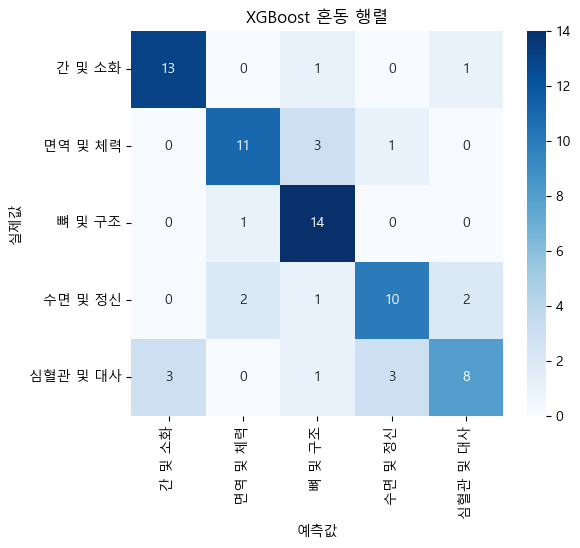


🧠 예측된 건강 카테고리: 뼈 및 구조
💊 최종 추천 건강기능식품 (상위 3개):
1. 베타카로틴 (고시형 품목, 뼈 및 구조)
2. 비타민 C (고시형 품목, 뼈 및 구조)
3. 칼슘 (고시형 품목, 뼈 및 구조)


In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_final_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# 📌 SBERT 모델 로드 (한국어 특화 모델)
symptom_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 📌 증상-건강 카테고리 매핑 추가
symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사",
    "숨이 차다": "심혈관 및 대사",
    "심장이 두근거린다": "심혈관 및 대사",
    "혈압이 높다": "심혈관 및 대사",
    "손발이 차다": "심혈관 및 대사",
    "당뇨가 있다": "심혈관 및 대사",
    "살이 많이 찐다": "심혈관 및 대사",
    "비만이 걱정된다": "심혈관 및 대사",
    "고혈당이 있다": "심혈관 및 대사",
    "속이 메스껍다": "간 및 소화",
    "속이 쓰리다": "간 및 소화",
    "가스가 자주 찬다": "간 및 소화",
    "소화가 잘 안된다": "간 및 소화",
    "소변 색이 짙다": "간 및 소화",
    "변비가 있다": "간 및 소화",
    "설사를 자주 한다": "간 및 소화",
    "복부팽만감이 있다": "간 및 소화",
    "감기에 자주 걸린다": "면역 및 체력",
    "몸이 쉽게 피곤하다": "면역 및 체력",
    "기운이 없다": "면역 및 체력",
    "근육통이 있다": "면역 및 체력",
    "면역력이 약하다": "면역 및 체력",
    "잠을 잘 못 잔다": "수면 및 정신",
    "스트레스를 많이 받는다": "수면 및 정신",
    "우울감을 느낀다": "수면 및 정신",
    "불안하다": "수면 및 정신",
    "집중력이 떨어진다": "수면 및 정신",
    "무릎이 아프다": "뼈 및 구조",
    "허리가 아프다": "뼈 및 구조",
    "관절이 뻣뻣하다": "뼈 및 구조",
    "골다공증이 걱정된다": "뼈 및 구조",
    "등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# 📌 TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(symptom_data['text'])

# 📌 SBERT 벡터화
symptom_vectors = np.array([symptom_model.encode(text) for text in symptom_data['text']])

# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 📌 SMOTE 적용 (데이터 불균형 해결)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)

# 📌 XGBoost 학습 (과적합 방지 적용)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 모델 학습 시 과적합 방지를 위한 하이퍼파라미터 조정
model = XGBClassifier(
    n_estimators=300,   # 트리 개수 줄임
    learning_rate=0.01, # 학습률 낮춤
    max_depth=4,        # 트리 깊이 제한
    subsample=0.8,      # 부분 샘플링 (80% 데이터 사용)
    colsample_bytree=0.8, # 컬럼 샘플링 (80% 컬럼 사용)
    random_state=42
)
model.fit(X_train, y_train)

# 📌 평가 (정확도 & 혼동행렬 확인)
y_pred = model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()


# 📌 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 📌 추천 함수 (고시형/개별 인정형 포함)
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    
    # 증상과 가장 유사한 건강 카테고리 예측
    symptom_similarities = [
        (util.cos_sim(input_vector, symptom_model.encode(row['text']))[0][0].item(), row['건강 카테고리']) 
        for _, row in symptom_data.iterrows()
    ]
    predicted_category = max(symptom_similarities, key=lambda x: x[0])[1]
    
    # 추천 제품 필터링 (고시형/개별 인정형 포함)
    recommended_products = [
        (row['품목명'], row['형태'], row['건강 카테고리'])
        for _, row in combined_data.iterrows() 
        if row['건강 카테고리'] == predicted_category
    ]
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    
    for idx, (name, kind, category) in enumerate(recommended_products[:top_n]):
        print(f"{idx+1}. {name} ({kind}, {category})")  # 유형 포함 출력

# 📌 예제 실행
user_input = "여드름이 많이 나욘"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)

# sentence-transformers/all-MiniLM-L6-v2 모델 사용했을 때

📈 모델 정확도: 0.6000

📊 분류 성능 보고서 (Classification Report):
              precision    recall  f1-score   support

      간 및 소화       0.62      0.67      0.65        15
     면역 및 체력       0.73      0.53      0.62        15
      뼈 및 구조       0.67      0.67      0.67        15
     수면 및 정신       0.50      0.40      0.44        15
    심혈관 및 대사       0.52      0.73      0.61        15

    accuracy                           0.60        75
   macro avg       0.61      0.60      0.60        75
weighted avg       0.61      0.60      0.60        75



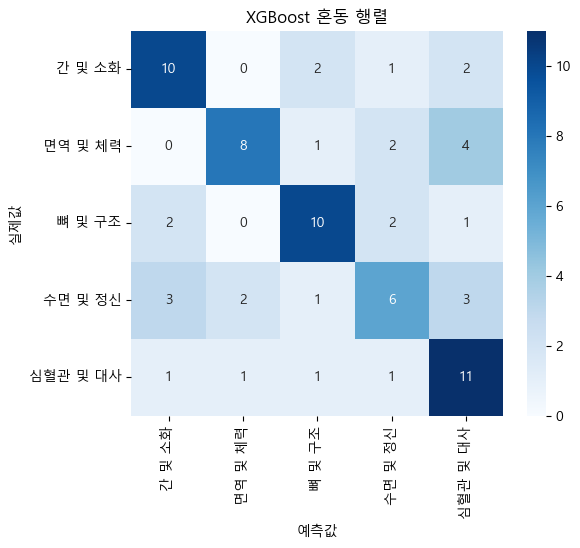


🧠 예측된 건강 카테고리: 뼈 및 구조
💊 최종 추천 건강기능식품 (상위 3개):
1. 베타카로틴 (고시형 품목, 뼈 및 구조)
2. 비타민 C (고시형 품목, 뼈 및 구조)
3. 칼슘 (고시형 품목, 뼈 및 구조)


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_final_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# 📌 SBERT 모델 로드 (한국어 특화 모델)
symptom_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 📌 증상-건강 카테고리 매핑 추가
symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사",
    "숨이 차다": "심혈관 및 대사",
    "심장이 두근거린다": "심혈관 및 대사",
    "혈압이 높다": "심혈관 및 대사",
    "손발이 차다": "심혈관 및 대사",
    "당뇨가 있다": "심혈관 및 대사",
    "살이 많이 찐다": "심혈관 및 대사",
    "비만이 걱정된다": "심혈관 및 대사",
    "고혈당이 있다": "심혈관 및 대사",
    "속이 메스껍다": "간 및 소화",
    "속이 쓰리다": "간 및 소화",
    "가스가 자주 찬다": "간 및 소화",
    "소화가 잘 안된다": "간 및 소화",
    "소변 색이 짙다": "간 및 소화",
    "변비가 있다": "간 및 소화",
    "설사를 자주 한다": "간 및 소화",
    "복부팽만감이 있다": "간 및 소화",
    "감기에 자주 걸린다": "면역 및 체력",
    "몸이 쉽게 피곤하다": "면역 및 체력",
    "기운이 없다": "면역 및 체력",
    "근육통이 있다": "면역 및 체력",
    "면역력이 약하다": "면역 및 체력",
    "잠을 잘 못 잔다": "수면 및 정신",
    "스트레스를 많이 받는다": "수면 및 정신",
    "우울감을 느낀다": "수면 및 정신",
    "불안하다": "수면 및 정신",
    "집중력이 떨어진다": "수면 및 정신",
    "무릎이 아프다": "뼈 및 구조",
    "허리가 아프다": "뼈 및 구조",
    "관절이 뻣뻣하다": "뼈 및 구조",
    "골다공증이 걱정된다": "뼈 및 구조",
    "등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)

# 📌 TF-IDF 벡터화
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(symptom_data['text'])

# 📌 SBERT 벡터화
symptom_vectors = np.array([symptom_model.encode(text) for text in symptom_data['text']])

# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 📌 SMOTE 적용 (데이터 불균형 해결)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)

# 📌 XGBoost 학습 (과적합 방지 적용)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 모델 학습 시 과적합 방지를 위한 하이퍼파라미터 조정
model = XGBClassifier(
    n_estimators=300,   # 트리 개수 줄임
    learning_rate=0.01, # 학습률 낮춤
    max_depth=4,        # 트리 깊이 제한
    subsample=0.8,      # 부분 샘플링 (80% 데이터 사용)
    colsample_bytree=0.8, # 컬럼 샘플링 (80% 컬럼 사용)
    random_state=42
)
model.fit(X_train, y_train)

# 📌 평가 (정확도 & 혼동행렬 확인)
y_pred = model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()


# 📌 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 📌 추천 함수 (고시형/개별 인정형 포함)
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = symptom_model.encode(user_input).reshape(1, -1)
    
    # 증상과 가장 유사한 건강 카테고리 예측
    symptom_similarities = [
        (util.cos_sim(input_vector, symptom_model.encode(row['text']))[0][0].item(), row['건강 카테고리']) 
        for _, row in symptom_data.iterrows()
    ]
    predicted_category = max(symptom_similarities, key=lambda x: x[0])[1]
    
    # 추천 제품 필터링 (고시형/개별 인정형 포함)
    recommended_products = [
        (row['품목명'], row['형태'], row['건강 카테고리'])
        for _, row in combined_data.iterrows() 
        if row['건강 카테고리'] == predicted_category
    ]
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    
    for idx, (name, kind, category) in enumerate(recommended_products[:top_n]):
        print(f"{idx+1}. {name} ({kind}, {category})")  # 유형 포함 출력

# 📌 예제 실행
user_input = "여드름이 많이 나욘"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)

# snunlp/KR-SBERT-V40K-klueNLI-augST모델 사용하기!->정확도 75%에서 더 올리기!

# BM-K/KoSimCSE-roberta-multitask 모델 사용!

In [62]:
pip install transformers torch

Note: you may need to restart the kernel to use updated packages.


In [67]:
import torch

📈 모델 정확도: 0.8442

📊 분류 성능 보고서 (Classification Report):
              precision    recall  f1-score   support

      간 및 소화       0.94      0.94      0.94        16
     면역 및 체력       0.83      0.67      0.74        15
      뼈 및 구조       0.79      1.00      0.88        15
     수면 및 정신       0.87      0.81      0.84        16
    심혈관 및 대사       0.80      0.80      0.80        15

    accuracy                           0.84        77
   macro avg       0.85      0.84      0.84        77
weighted avg       0.85      0.84      0.84        77



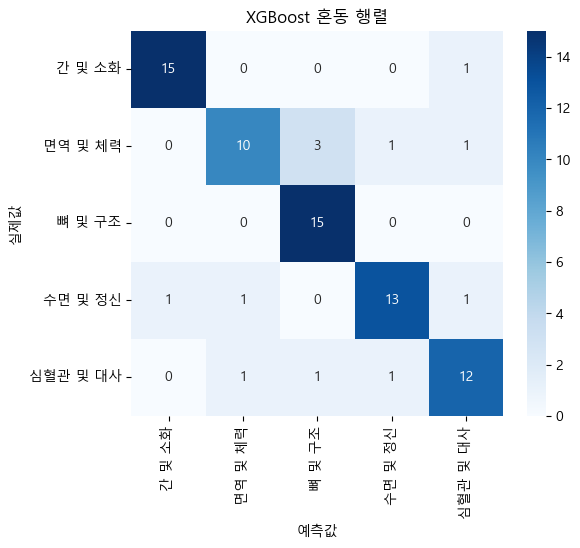


🧠 예측된 건강 카테고리: 뼈 및 구조
💊 최종 추천 건강기능식품 (상위 3개):
1. 베타카로틴 (고시형 품목, 뼈 및 구조)
2. 비타민 C (고시형 품목, 뼈 및 구조)
3. 칼슘 (고시형 품목, 뼈 및 구조)


In [72]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 📌 데이터 불러오기
individual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\individual_data.xlsx')
nonindividual_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\nonindividual_data.xlsx')
symptom_data = pd.read_excel('C:\\Users\\dbwld\\OneDrive\\바탕 화면\\Project\\symptom_final_data.xlsx')

# 개인형 & 비개인형 데이터 결합
individual_data['형태'] = '개별 인정형 품목'
nonindividual_data['형태'] = '고시형 품목'
combined_data = pd.concat([individual_data, nonindividual_data], ignore_index=True)

# 📌 SBERT 모델 로드 (한국어 특화 모델)
# Load model directly
from transformers import AutoTokenizer, AutoModel

# 📌 KoSimCSE 모델 로드
model_name = "BM-K/KoSimCSE-roberta-multitask"
tokenizer = AutoTokenizer.from_pretrained(model_name)
symptom_model = AutoModel.from_pretrained(model_name)
warning_model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')

# 📌 증상-건강 카테고리 매핑 추가
symptom_to_category = {
    "가슴이 답답하다": "심혈관 및 대사",
    "숨이 차다": "심혈관 및 대사",
    "심장이 두근거린다": "심혈관 및 대사",
    "혈압이 높다": "심혈관 및 대사",
    "손발이 차다": "심혈관 및 대사",
    "당뇨가 있다": "심혈관 및 대사",
    "살이 많이 찐다": "심혈관 및 대사",
    "비만이 걱정된다": "심혈관 및 대사",
    "고혈당이 있다": "심혈관 및 대사",
    "속이 메스껍다": "간 및 소화",
    "속이 쓰리다": "간 및 소화",
    "가스가 자주 찬다": "간 및 소화",
    "소화가 잘 안된다": "간 및 소화",
    "소변 색이 짙다": "간 및 소화",
    "변비가 있다": "간 및 소화",
    "설사를 자주 한다": "간 및 소화",
    "복부팽만감이 있다": "간 및 소화",
    "감기에 자주 걸린다": "면역 및 체력",
    "몸이 쉽게 피곤하다": "면역 및 체력", 
    "콧물이 난다.": "면역 및 체력",
    "기운이 없다": "면역 및 체력",
    "너무 춥다.": "면역 및 체력",
    "근육통이 있다": "면역 및 체력",
    "면역력이 약하다": "면역 및 체력",
    "잠을 잘 못 잔다": "수면 및 정신",
    "스트레스를 많이 받는다": "수면 및 정신",
    "우울감을 느낀다": "수면 및 정신",
    "불안하다": "수면 및 정신",
    "집중력이 떨어진다": "수면 및 정신",
    "무릎이 아프다": "뼈 및 구조",
    "허리가 아프다": "뼈 및 구조",
    "관절이 뻣뻣하다": "뼈 및 구조",
    "골다공증이 걱정된다": "뼈 및 구조",
    "등이 결린다": "뼈 및 구조"
}

# 증상 데이터에 추가
symptom_df = pd.DataFrame(list(symptom_to_category.items()), columns=['text', '건강 카테고리'])
symptom_data = pd.concat([symptom_data, symptom_df], ignore_index=True)



# 문장을 벡터로 변환하는 함수
def encode_text(text):
    inputs = tokenizer([text], return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = symptom_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# 📌 SBERT 벡터화
symptom_vectors = np.array([encode_text(text) for text in symptom_data['text']])
# 📌 라벨 인코딩
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(symptom_data['건강 카테고리'])

# 📌 SMOTE 적용 (데이터 불균형 해결)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(symptom_vectors, encoded_labels)

# 📌 XGBoost 학습 (과적합 방지 적용)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# 모델 학습 시 과적합 방지를 위한 하이퍼파라미터 조정
model = XGBClassifier(
    n_estimators=300,   # 트리 개수 줄임
    learning_rate=0.01, # 학습률 낮춤
    max_depth=4,        # 트리 깊이 제한
    subsample=0.8,      # 부분 샘플링 (80% 데이터 사용)
    colsample_bytree=0.8, # 컬럼 샘플링 (80% 컬럼 사용)
    random_state=42
)
model.fit(X_train, y_train)

# 📌 평가 (정확도 & 혼동행렬 확인)
y_pred = model.predict(X_test)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 모델 정확도: {accuracy:.4f}")

# 정밀도, 재현율, F1-score 출력
print("\n📊 분류 성능 보고서 (Classification Report):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 혼동 행렬 출력
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("XGBoost 혼동 행렬")
plt.show()


# 📌 지병 및 특이사항 필터링 함수
def is_safe_for_condition(product_warning, user_condition, threshold=0.45):
    if isinstance(product_warning, float) and pd.isna(product_warning):
        return True
    bullets = product_warning.split('\n')
    for bullet in bullets:
        bullet = bullet.strip()
        if bullet == "":
            continue
        sim = util.cos_sim(warning_model.encode(bullet).reshape(1, -1), warning_model.encode(user_condition).reshape(1, -1))[0][0].item()
        if sim >= threshold:
            return False
    return True

# 📌 추천 함수 (고시형/개별 인정형 포함)
def recommend_health_products(user_input, user_condition, top_n=5):
    input_vector = encode_text(user_input).reshape(1, -1)
    
   # 증상과 가장 유사한 건강 카테고리 예측
    symptom_similarities = [
        (util.cos_sim(input_vector, encode_text(row['text']).reshape(1, -1))[0][0].item(), row['건강 카테고리']) 
        for _, row in symptom_data.iterrows()
    ]
    predicted_category = max(symptom_similarities, key=lambda x: x[0])[1]

    
    # 추천 제품 필터링 (고시형/개별 인정형 포함)
    recommended_products = [
        (row['품목명'], row['형태'], row['건강 카테고리'])
        for _, row in combined_data.iterrows() 
        if row['건강 카테고리'] == predicted_category
    ]
    
    print(f"\n🧠 예측된 건강 카테고리: {predicted_category}")
    print(f"💊 최종 추천 건강기능식품 (상위 {top_n}개):")
    
    for idx, (name, kind, category) in enumerate(recommended_products[:top_n]):
        print(f"{idx+1}. {name} ({kind}, {category})")  # 유형 포함 출력

# 📌 예제 실행
user_input = "팔이 저려요"
user_condition = "임산부"
recommend_health_products(user_input, user_condition, top_n=3)